# Censored regression in PyMC3 [WORK IN PROGRESS]
**Author:** [Ben Vincent](https://github.com/drbenvincent)

This notebook provides an example of how to do linear regression in the case where you have censored observations. Truncation and censoring are both missing data problems:
- **censored data:** data outside the range of some measurement limits are set at those floor and ceiling values
- **truncated data:** data outside the range of some measurement limits are simply absent.

In this notebook we consider interval censoring, where we have both upper and lower censoring bounds.

We simulate some true data, then apply censoring bounds. We fit a standard linear regression model to both the raw and the censored datasets to see that our estimates may be biased. Then we look at a censored regression model.

Optional: If you want to use autoformatter, then 

    pip install nb-black

In [1]:
%load_ext lab_black

In [2]:
import numpy as np
import pandas as pd

# plotting
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 14})

import pymc3 as pm
import arviz as az
from scipy.stats import norm

print(f"Running on PyMC3 v{pm.__version__}")
print(f"Running on arviz v{az.__version__}")

Running on PyMC3 v3.8
Running on arviz v0.7.0


## Define options

In [3]:
SEED = 123

n_samples = 1_000
m = 1
c = 0
N = 100

censor_bounds = [-1.5, 1.5]

sample_options = {
    "tune": 1_000,
    "draws": n_samples,
    "chains": 2,
    "cores": 2,
    "nuts_kwargs": {"target_accept": 0.95},
    "random_seed": SEED,
}

np.random.seed(SEED)

## Create synthetic dataset

In [4]:
def make_data():
    x = np.random.randn(N)
    ϵ = np.random.randn(N) * 0.5
    y = m * x + c + ϵ
    return (x, y)


x, y = make_data()

In [5]:
def censor_y(x, y, censor_bounds):
    # set up data
    xc = x
    yc = y.copy()
    # indicator variables (boolean) of what is censored
    censor_low = yc < censor_bounds[0]
    censor_high = yc > censor_bounds[1]
    censored = (censor_low) | (censor_high)
    # do the censoring
    yc[censor_low] = censor_bounds[0]
    yc[censor_high] = censor_bounds[1]
    return xc, yc, censor_low, censor_high, censored


xc, yc, censor_low, censor_high, censored = censor_y(x, y, censor_bounds)
n_censor_low = sum(censor_low)
n_censor_high = sum(censor_high)

In [6]:
print(sum(censored))
print(n_censor_low)
print(n_censor_high)

23
10
13


In [7]:
def plot_true(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    x = np.array([-3, 3])
    ax.plot(x, m * x + c, "r", lw=3, label="True")
    ax.legend()

[Text(0, 0.5, 'y'), Text(0.5, 0, 'x'), Text(0.5, 1.0, 'Censored data')]

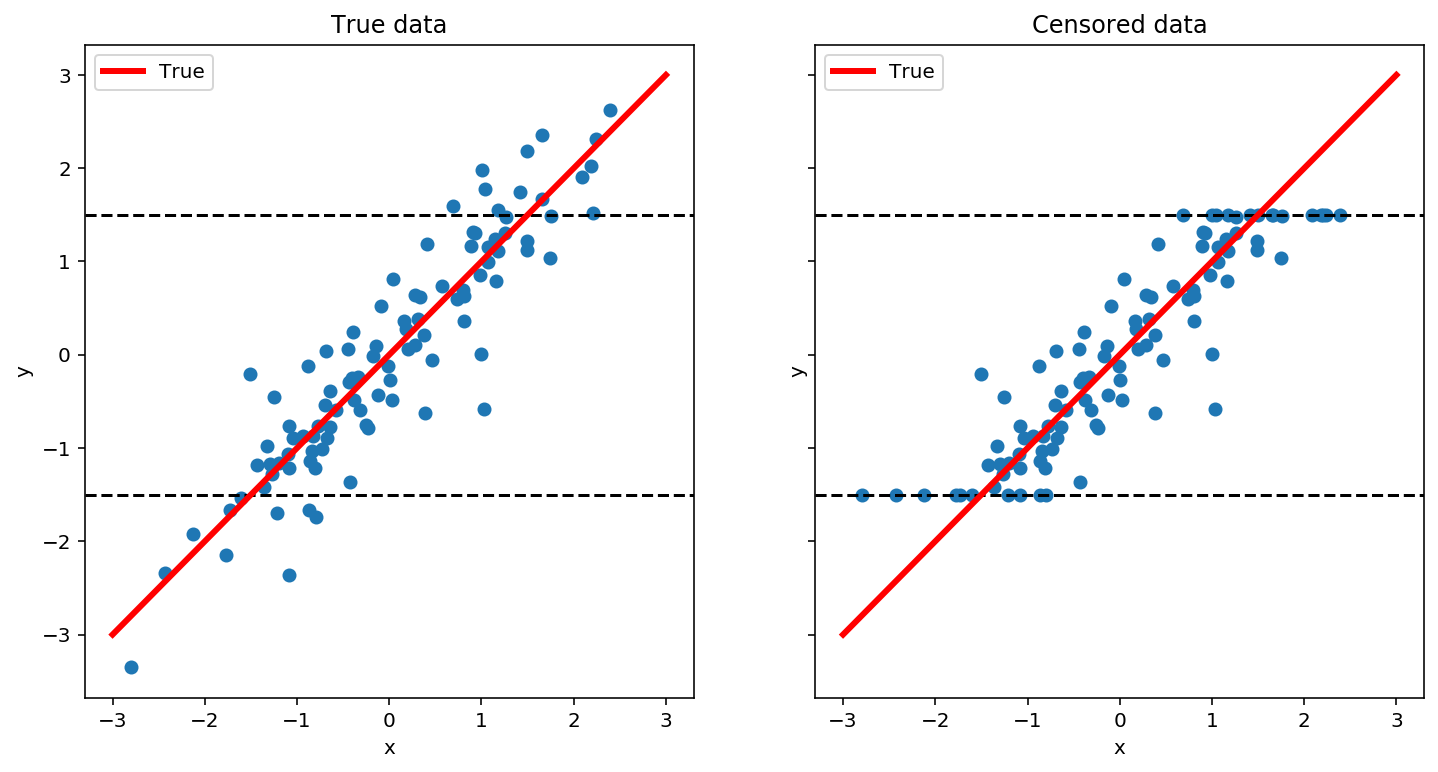

In [8]:
def plot_data(x, y, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    ax.scatter(x, y)
    for bound in censor_bounds:
        ax.axhline(y=bound, c="k", ls="--")
    ax.set(xlabel="x", ylabel="y")
    return ax


fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

_ = plot_data(x, y, ax=ax[0])
plot_true(ax=ax[0])
ax[0].set(title="True data", xlabel="x", ylabel="y")

_ = plot_data(xc, yc, ax=ax[1])
plot_true(ax=ax[1])
ax[1].set(title="Censored data", xlabel="x", ylabel="y")

Visualise the process in more detail...

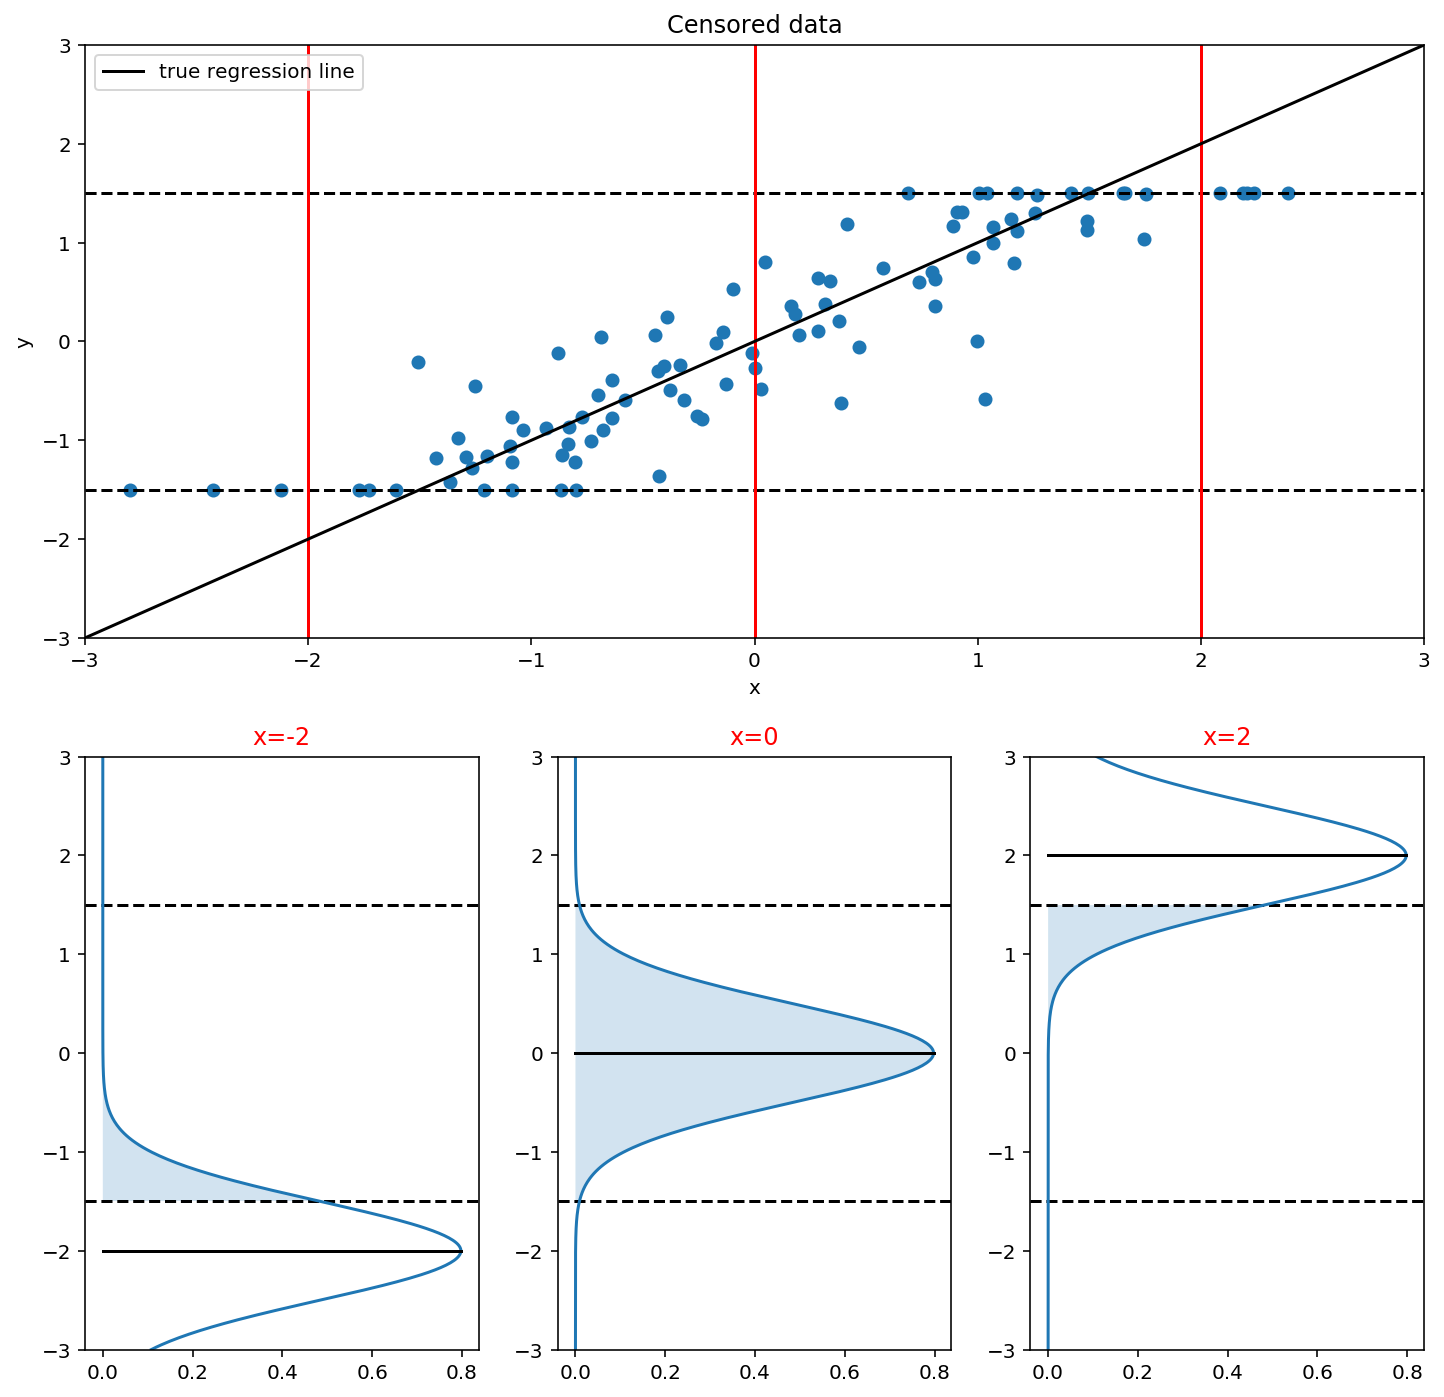

In [9]:
fig, ax = plt.subplots(figsize=(12, 12))

# plot data
ax1 = plt.subplot(2, 1, 1)
_ = plot_data(xc, yc, ax=ax1)
# plot cross sections
x_sections = [-2, 0, 2]
for _x in x_sections:
    ax1.axvline(x=_x, c="r")

ax1.plot([-3, 3], [-3, 3], "k", label="true regression line")
ax1.set(title="Censored data", xlim=(-3, 3), ylim=(-3, 3))
ax1.legend()


def plot_cross_section(ax, x, μ):
    ax.set(ylim=(-3, 3))
    ax.set_title(f"x={x}", color="r")
    # plot bounds
    for bound in censor_bounds:
        ax.axhline(y=bound, c="k", ls="--")
    # plot normal distribution
    y = np.linspace(-3, 3, 500)
    x = norm.pdf(y, loc=μ, scale=0.5)
    ax.plot(x, y)
    ax.fill_betweenx(
        y, 0, x, where=(y > censor_bounds[0]) & (y < censor_bounds[1]), alpha=0.2
    )
    # plot line to mu
    ax.plot([0, np.max(x)], [μ, μ], "k")


ax2 = plt.subplot(2, 3, 4)
plot_cross_section(ax2, x=-2, μ=-2)

ax3 = plt.subplot(2, 3, 5)
plot_cross_section(ax3, x=0, μ=0)

ax4 = plt.subplot(2, 3, 6)
plot_cross_section(ax4, x=2, μ=2)

## Regular regression applied to raw and censored data

In [10]:
def regression(x, y):

    with pm.Model() as model:
        m = pm.Normal("m", mu=0, sd=1)
        c = pm.Normal("c", mu=0, sd=1)
        σ = pm.HalfNormal("σ", sd=1)
        y_likelihood = pm.Normal("y_likelihood", mu=m * x + c, sd=σ, observed=y)

    with model:
        trace = pm.sample(**sample_options)

    return model, trace

In [11]:
model, trace = regression(x, y)
_, trace_t = regression(xc, yc)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, c, m]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, c, m]


If you want, you can visualise the traces with:

    pm.traceplot(trace, var_names=["m", "c", "σ"])
    pm.traceplot(trace_t, var_names=["m", "c", "σ"])

Visualise...

In [12]:
def plot_posterior_predictive(trace, ax=None):

    if ax is None:
        fig, ax = plt.subplots()

    # plot posterior predictive
    x_ppc = np.array([-3, +3])

    for n in range(n_samples):
        y_ppc = x_ppc * trace["m"][n] + trace["c"][n]
        ax.plot(x_ppc, y_ppc, "k", alpha=0.01, rasterized=True)

    return ax

In [13]:
x

array([-1.0856306 ,  0.99734545,  0.2829785 , -1.50629471, -0.57860025,
        1.65143654, -2.42667924, -0.42891263,  1.26593626, -0.8667404 ,
       -0.67888615, -0.09470897,  1.49138963, -0.638902  , -0.44398196,
       -0.43435128,  2.20593008,  2.18678609,  1.0040539 ,  0.3861864 ,
        0.73736858,  1.49073203, -0.93583387,  1.17582904, -1.25388067,
       -0.6377515 ,  0.9071052 , -1.4286807 , -0.14006872, -0.8617549 ,
       -0.25561937, -2.79858911, -1.7715331 , -0.69987723,  0.92746243,
       -0.17363568,  0.00284592,  0.68822271, -0.87953634,  0.28362732,
       -0.80536652, -1.72766949, -0.39089979,  0.57380586,  0.33858905,
       -0.01183049,  2.39236527,  0.41291216,  0.97873601,  2.23814334,
       -1.29408532, -1.03878821,  1.74371223, -0.79806274,  0.02968323,
        1.06931597,  0.89070639,  1.75488618,  1.49564414,  1.06939267,
       -0.77270871,  0.79486267,  0.31427199, -1.32626546,  1.41729905,
        0.80723653,  0.04549008, -0.23309206, -1.19830114,  0.19

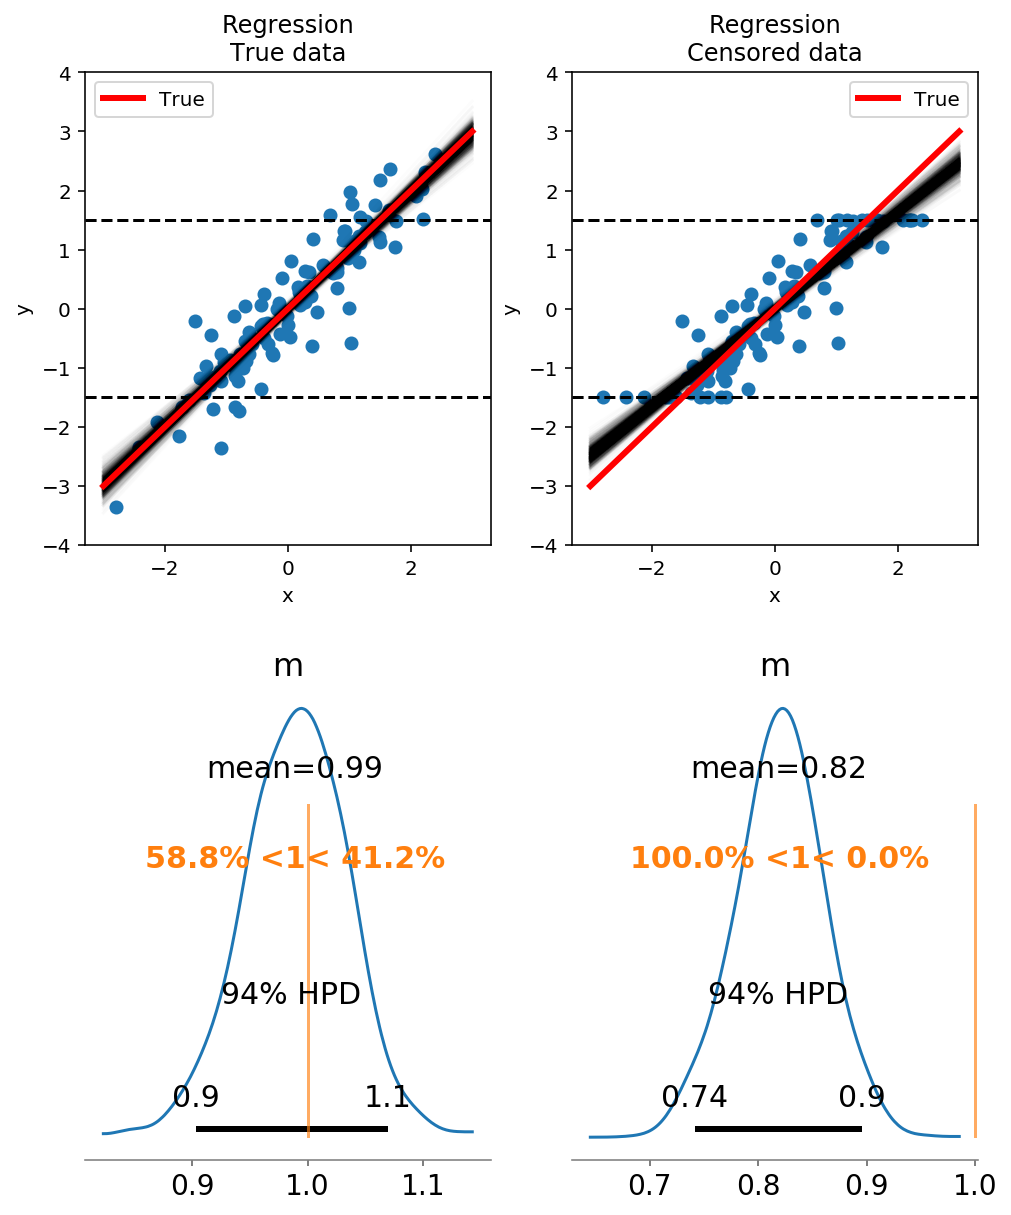

In [14]:
xfig, ax = plt.subplots(2, 2, figsize=(8, 10))

data_ylim = [-4, 4]

# True data =================================================
# data space
_ = plot_data(x, y, ax=ax[0, 0])
_ = plot_posterior_predictive(trace, ax=ax[0, 0])
ax[0, 0].set(title="Regression\nTrue data", xlabel="x", ylabel="y", ylim=data_ylim)
plot_true(ax=ax[0, 0])
# parameter space
az.plot_posterior(trace, var_names=["m"], ax=ax[1, 0], ref_val=m)

# Truncated data ============================================
_ = plot_data(xc, yc, ax=ax[0, 1])
ax[0, 1].set(title="Regression\nCensored data", xlabel="x", ylabel="y", ylim=data_ylim)
_ = plot_posterior_predictive(trace_t, ax=ax[0, 1])
plot_true(ax=ax[0, 1])
# parameter space
az.plot_posterior(trace_t, var_names=["m"], ax=ax[1, 1], ref_val=m)


# spacing between rows
plt.subplots_adjust(hspace=0.3)

We can see that regression on censored data produces bias in out estimate of the slope.

## Cheating: truncating the censored values and doing truncated regression
First thing we will do is a hacky attempt to truncate the data which has been censored and run a truncted regression model. This is _not_ equal to censored regression but we are doing it to compare with actual censored regression later.

In [15]:
def truncated_regression(x, y):
    """Sample from a truncated linear regression model"""
    truncation_bounds = censor_bounds

    with pm.Model() as model:
        m = pm.Normal("m", mu=0, sd=1)
        c = pm.Normal("c", mu=0, sd=1)
        σ = pm.HalfNormal("σ", sd=1)
        y_likelihood = pm.TruncatedNormal(
            "y_likelihood",
            mu=m * x + c,
            sd=σ,
            observed=y,
            lower=truncation_bounds[0],
            upper=truncation_bounds[1],
        )

    with model:
        trace = pm.sample(**sample_options)

    return model, trace

In [16]:
def truncate_y(x, y, truncation_bounds):
    trunc = (y > truncation_bounds[0]) & (y < truncation_bounds[1])
    return (x[trunc], y[trunc])


# truncate at the censor bounds
xt, yt = truncate_y(xc, yc, censor_bounds)

# do truncated regression
_, trace_truncated = truncated_regression(xt, yt)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, c, m]


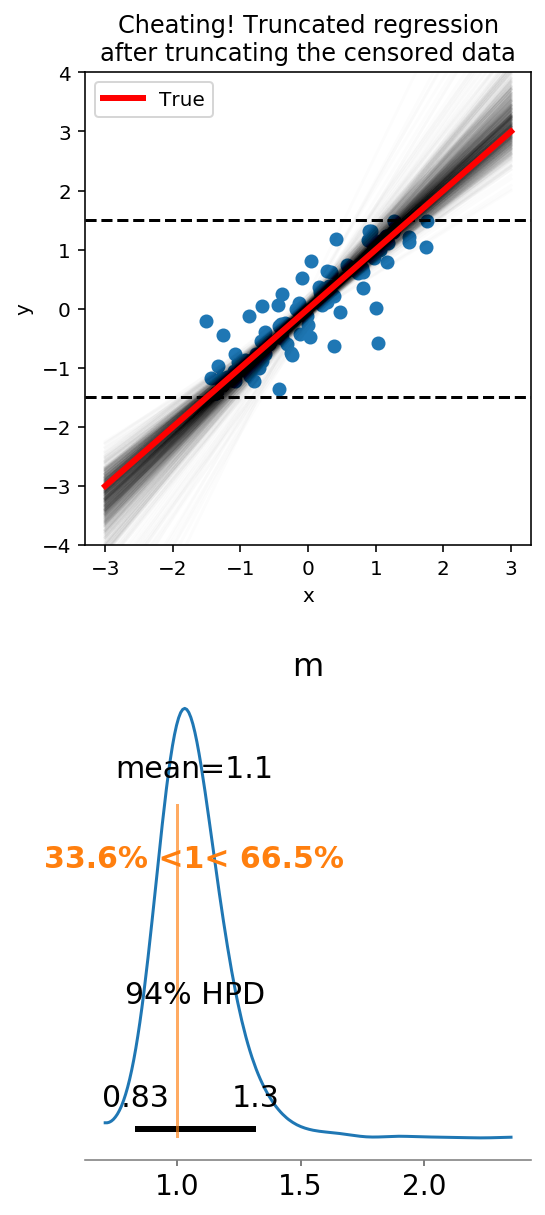

In [17]:
xfig, ax = plt.subplots(2, 1, figsize=(4, 10))

data_ylim = [-4, 4]

# True data =================================================
# data space
_ = plot_data(xt, yt, ax=ax[0])
_ = plot_posterior_predictive(trace_truncated, ax=ax[0])
ax[0].set(
    title="Cheating! Truncated regression\nafter truncating the censored data",
    xlabel="x",
    ylabel="y",
    ylim=data_ylim,
)
plot_true(ax=ax[0])
# parameter space
az.plot_posterior(trace_truncated, var_names=["m"], ax=ax[1], ref_val=m)

# spacing between rows
plt.subplots_adjust(hspace=0.3)

## Another cheat: setting data outside bounds as 'missing'

In [18]:
def missing_y(x, y, censor_bounds):
    # set up data
    xm = x
    ym = y.copy()
    # indicator variables (boolean) of what is censored
    missing_low = ym < censor_bounds[0]
    missing_high = ym > censor_bounds[1]
    missing = (missing_low) | (missing_high)
    # set dat aoutside bounds as missing
    ym[missing_low] = np.nan
    ym[censor_high] = np.nan
    return xm, ym, missing_low, missing_high, missing


# set data outside bounds as missing
xm, ym, missing_low, missing_high, missing = missing_y(x, y, censor_bounds)

In [19]:
data = pd.DataFrame({"x": xm, "y": ym})

In [20]:
def regression_missing(data):

    with pm.Model() as model:
        m = pm.Normal("m", mu=0, sd=1)
        c = pm.Normal("c", mu=0, sd=1)
        σ = pm.HalfNormal("σ", sd=1)
        y_likelihood = pm.Normal(
            "y_likelihood", mu=m * data.x + c, sd=σ, observed=data.y
        )

    with model:
        trace = pm.sample(**sample_options)

    return model, trace

In [21]:
# regular regression but with y outside of bounds are set as missing
model, trace_missing = regression_missing(data)

/Users/benjamv/opt/anaconda3/lib/python3.7/site-packages/pymc3/model.py:1506: ImputationWarning: Data in y_likelihood contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_likelihood_missing, σ, c, m]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcf91369990>,
      dtype=object)

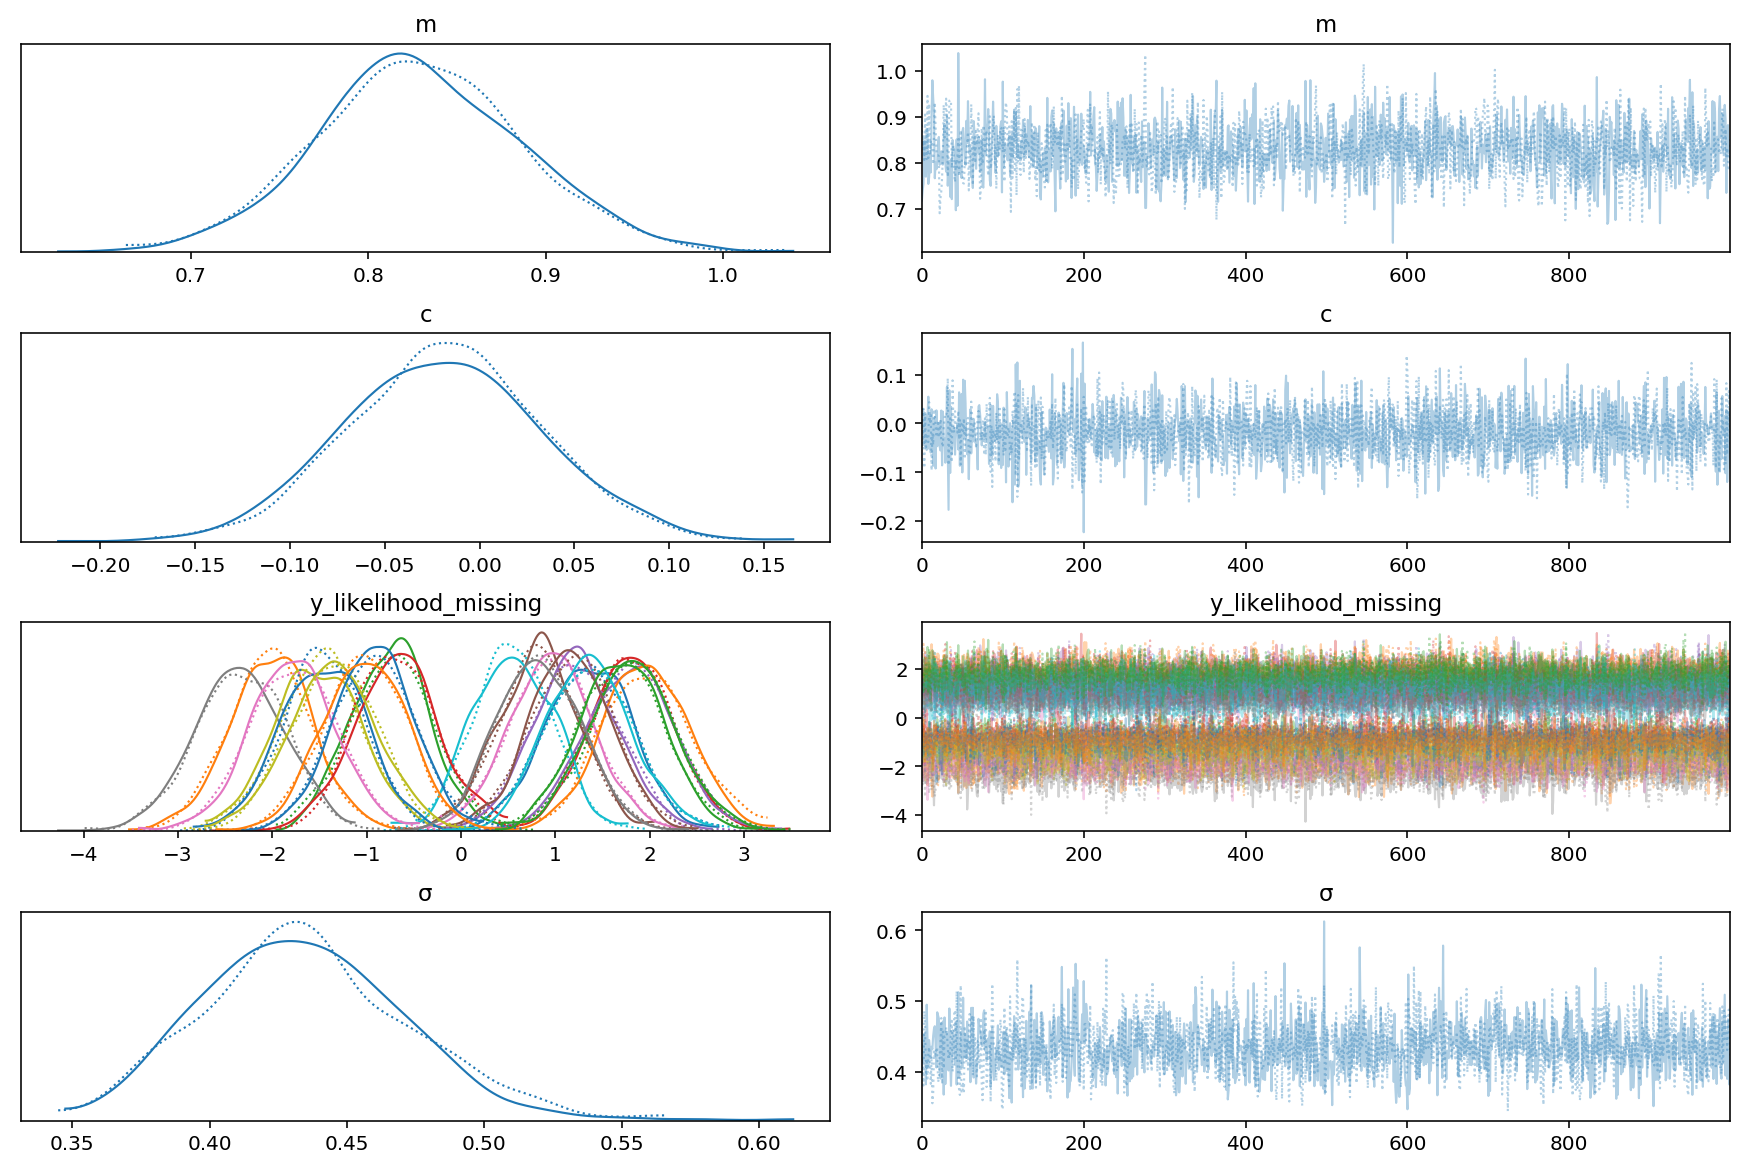

In [22]:
pm.traceplot(trace_missing)

You can see that the mising y values are being imputed. Although here I am not making an attempt to visualise these imputed values against the known true values.

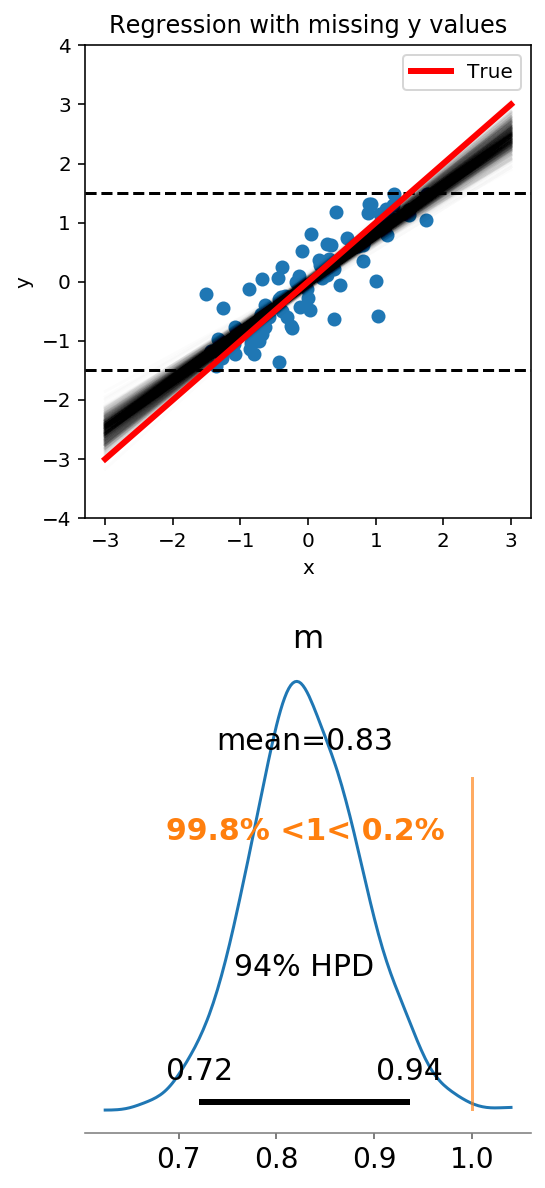

In [23]:
xfig, ax = plt.subplots(2, 1, figsize=(4, 10))

data_ylim = [-4, 4]

# True data =================================================
# data space
_ = plot_data(xm, ym, ax=ax[0])
_ = plot_posterior_predictive(trace_missing, ax=ax[0])
ax[0].set(
    title="Regression with missing y values", xlabel="x", ylabel="y", ylim=data_ylim,
)
plot_true(ax=ax[0])
# parameter space
az.plot_posterior(trace_missing, var_names=["m"], ax=ax[1], ref_val=m)

# spacing between rows
plt.subplots_adjust(hspace=0.3)

This does not work, in that it does not remove the bias in the slope parameter.

## Censored regression (aka Tobit regression)
This approach modifies the likelihood so that we have a normal distribution, but the likelihood at the bounds equals the probability mass of the upper and lower cutoffs.

In [24]:
def censored_regression(x, y):
    """Sample from a censored linear regression model"""

    #     with pm.Model() as model:
    #         m = pm.Normal("m", mu=0, sd=1)
    #         c = pm.Normal("c", mu=0, sd=1)
    #         σ = pm.HalfNormal("σ", sd=1)
    #         y_likelihood = pm.TruncatedNormal(
    #             "y_likelihood",
    #             mu=m * x + c,
    #             sd=σ,
    #             observed=y,
    #             lower=truncation_bounds[0],
    #             upper=truncation_bounds[1],
    #         )

    with model:
        trace = pm.sample(**sample_options)

    return model, trace

In [ ]:
_, trace_censored = censored_regression(xc, yc)

In [ ]:
pm.traceplot(trace_censored, var_names=["m", "c", "σ"])

# TEMPORARY Censored data notes
Based on https://docs.pymc.io/notebooks/censored_data.html 

In [27]:
import seaborn as sns

In [31]:
# Produce normally distributed samples
np.random.seed(1618)
size = 500
μ = 13.0
σ = 5.0
samples = np.random.normal(μ, σ, size)

# Set censoring limits
high = 16.0
low = -1.0

# Truncate samples
def truncate(samples, low, high):
    return samples[(samples > low) & (samples < high)]


# Censor samples
def censor(samples, low, high):
    truncated_samples = truncate(samples, low, high)

    censored_samples = samples.copy()
    censored_samples[censored_samples < low] = low
    censored_samples[censored_samples > high] = high

    n_right_censored = len(samples[samples >= high])
    n_left_censored = len(samples[samples <= low])
    n_observed = len(samples) - n_right_censored - n_left_censored
    return (
        censored_samples,
        truncated_samples,
        n_left_censored,
        n_right_censored,
        n_observed,
    )


truncated_samples = truncate(samples, low, high)
(
    censored_samples,
    truncated_samples,
    n_left_censored,
    n_right_censored,
    n_observed,
) = censor(samples, low, high)

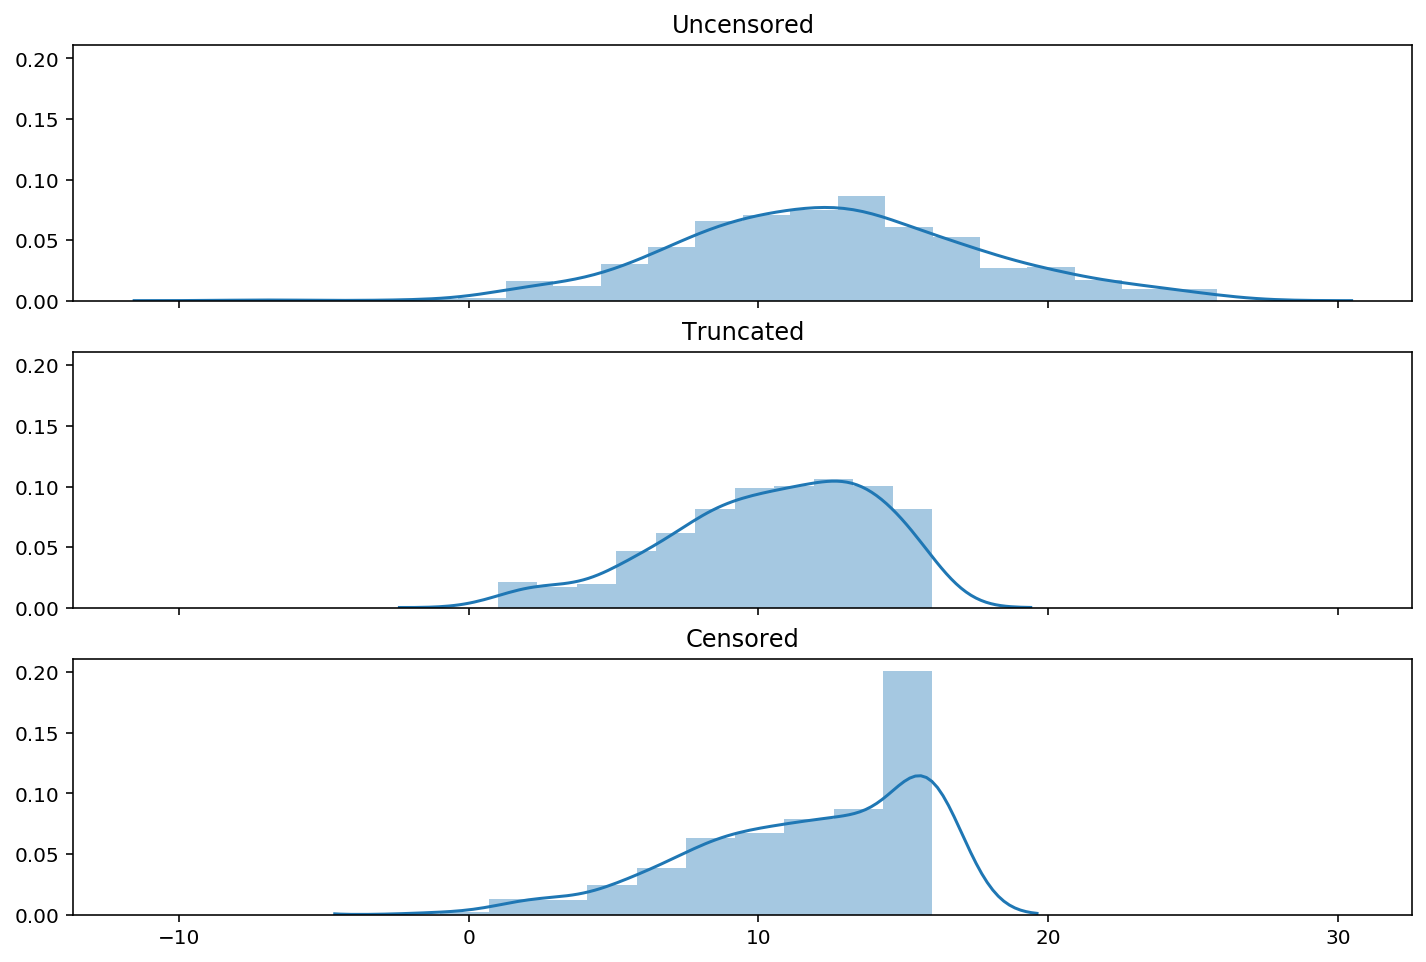

In [32]:
# Visualize uncensored and censored data
_, axarr = plt.subplots(nrows=3, figsize=[12, 8], sharex=True, sharey=True)
for i, data in enumerate([samples, truncated_samples, censored_samples]):
    sns.distplot(data, ax=axarr[i])
axarr[0].set_title("Uncensored")
axarr[1].set_title("Truncated")
axarr[2].set_title("Censored")
plt.show()

## Uncensored model

In [33]:
def uncensored_model(samples):
    with pm.Model() as model:
        mu = pm.Normal("mu", mu=0.0, sigma=(high - low) / 2.0)
        sigma = pm.HalfNormal("sigma", sigma=(high - low) / 2.0)
        observed = pm.Normal("observed", mu=mu, sigma=sigma, observed=samples)

    with model:
        trace = pm.sample(tune=1000)  # Increase `tune` to avoid divergences

    return trace

### Using uncensored data gives us the graound truth best inference about mu and sigma

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
INFO:pymc3:NUTS: [sigma, mu]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcfa75847d0>,
      dtype=object)

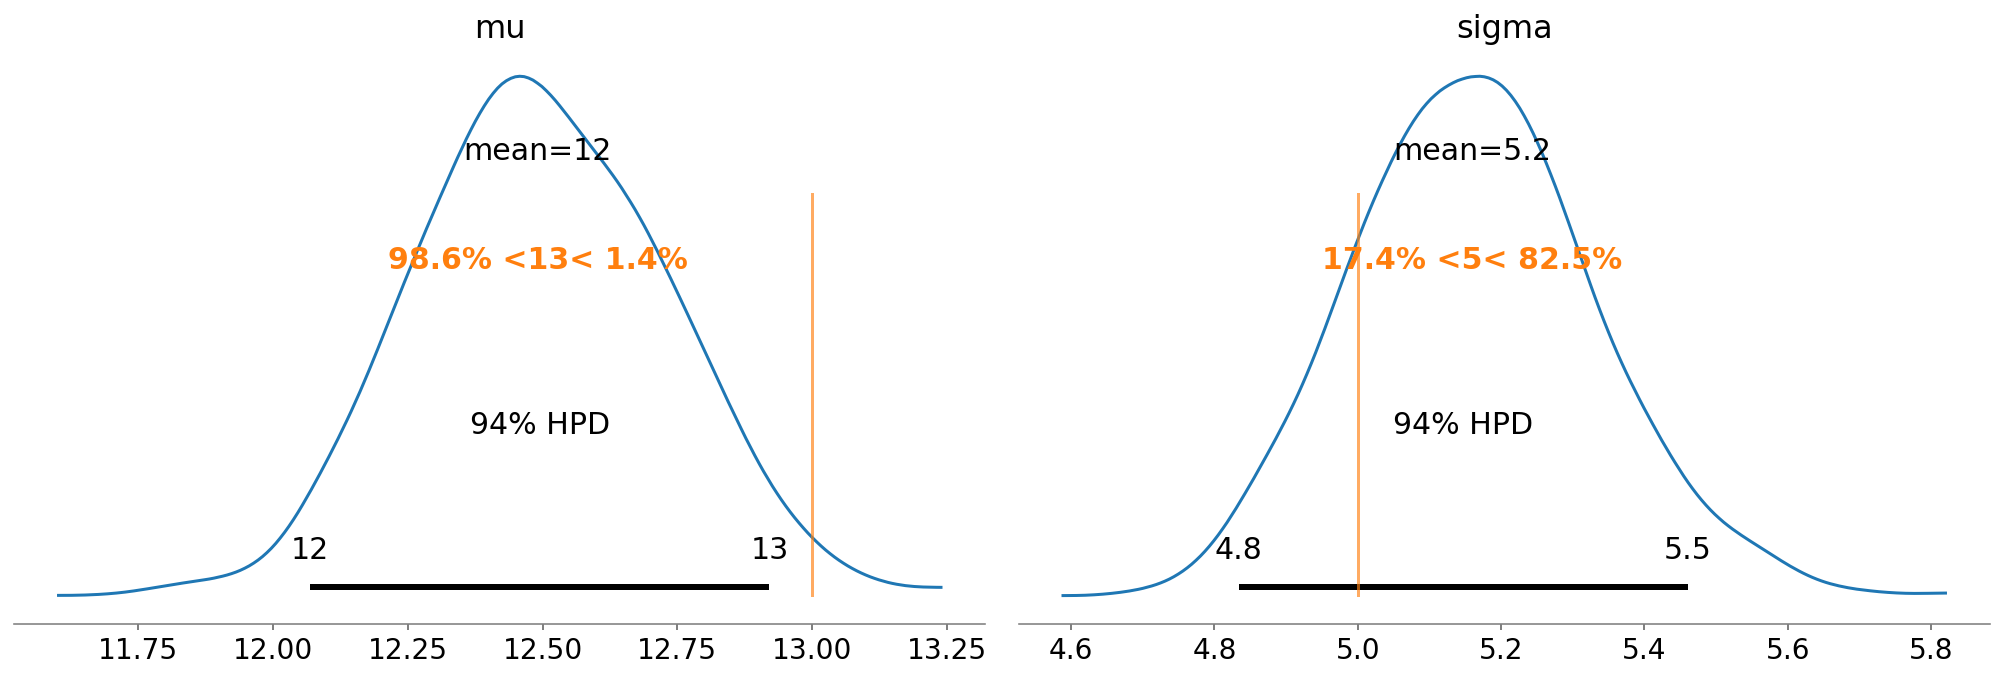

In [34]:
trace = uncensored_model(samples)
az.plot_posterior(trace, var_names=["mu", "sigma"], ref_val=[μ, σ])

### Biased estimation from truncated samples

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
INFO:pymc3:NUTS: [sigma, mu]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcf99a19a50>,
      dtype=object)

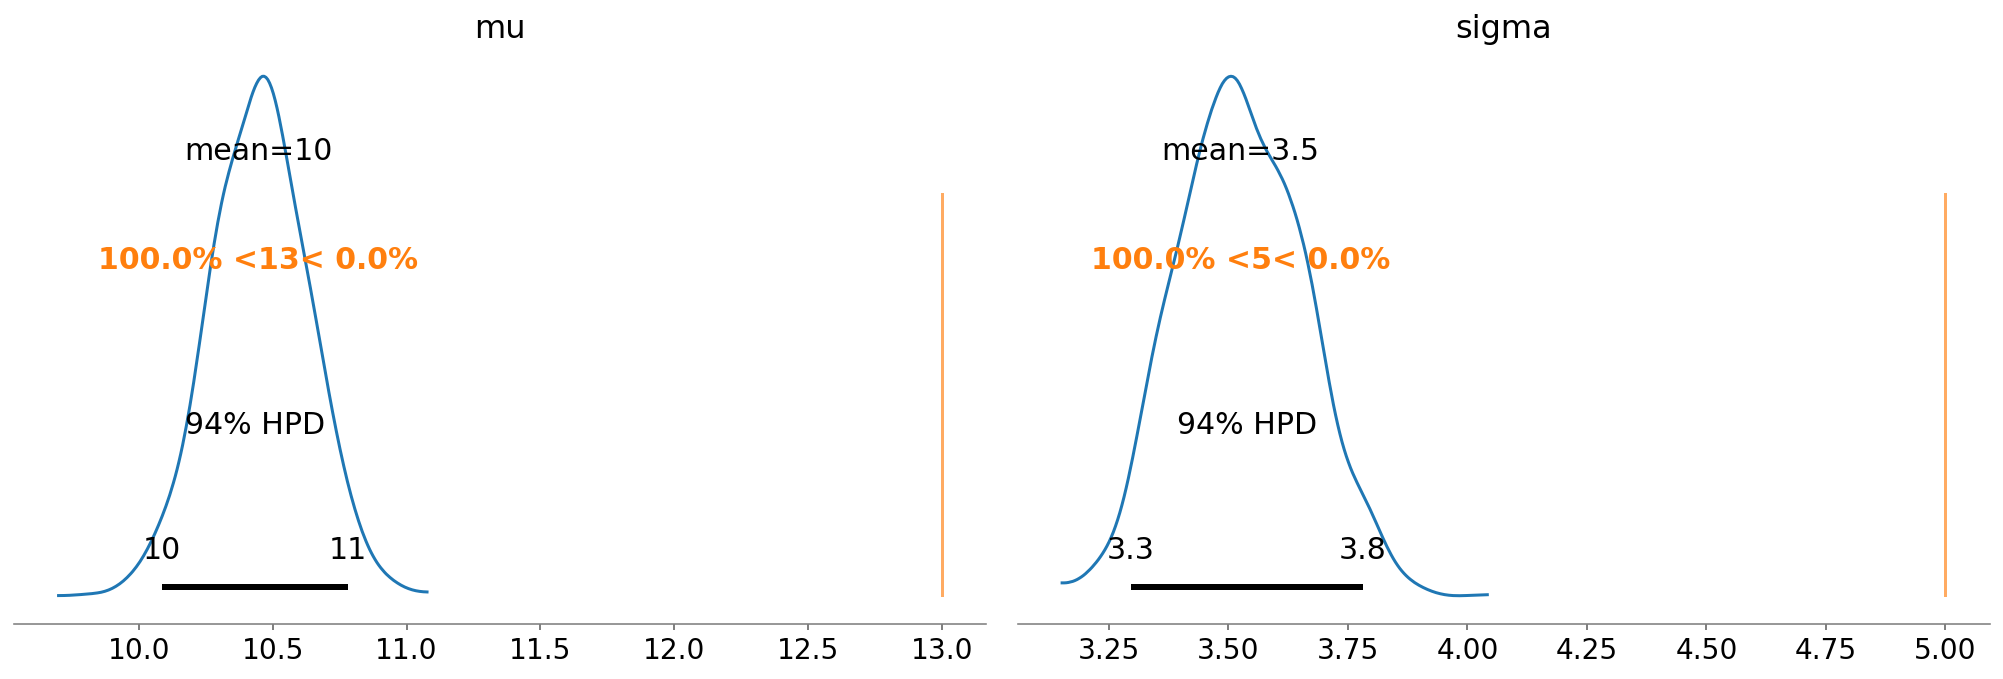

In [35]:
trace = uncensored_model(truncated_samples)
az.plot_posterior(trace, var_names=["mu", "sigma"], ref_val=[μ, σ])

### Biased estimation from censored samples

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
INFO:pymc3:NUTS: [sigma, mu]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcfc0d52a50>,
      dtype=object)

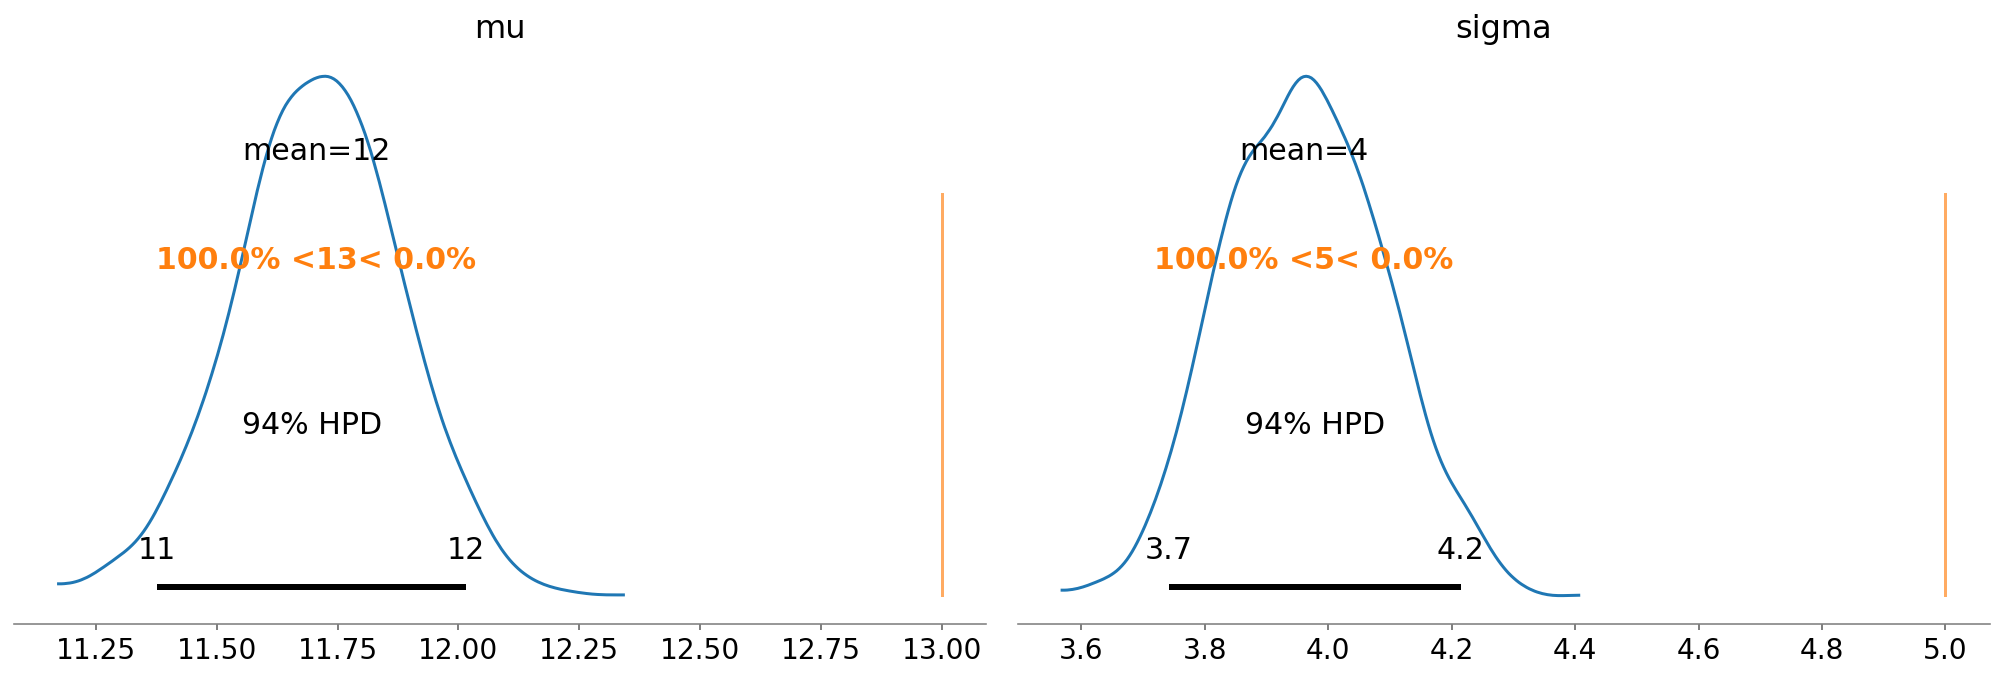

In [36]:
trace = uncensored_model(censored_samples)
az.plot_posterior(trace, var_names=["mu", "sigma"], ref_val=[μ, σ])

## Model 1 - Imputed Censored Model of Censored Data

In [37]:
def model1(samples):

    (
        censored_samples,
        truncated_samples,
        n_left_censored,
        n_right_censored,
        n_observed,
    ) = censor(samples, low, high)

    with pm.Model() as model:
        mu = pm.Normal("mu", mu=0.0, sigma=(high - low) / 2.0)
        sigma = pm.HalfNormal("sigma", sigma=(high - low) / 2.0)

        right_censored = pm.Bound(pm.Normal, lower=high)(
            "right_censored", mu=mu, sigma=sigma, shape=n_right_censored
        )
        left_censored = pm.Bound(pm.Normal, upper=low)(
            "left_censored", mu=mu, sigma=sigma, shape=n_left_censored
        )

        # note that we observe _truncated_ samples
        observed = pm.Normal(
            "observed", mu=mu, sigma=sigma, observed=truncated_samples, shape=n_observed
        )

    with model:
        trace = pm.sample(tune=1000)  # Increase `tune` to avoid divergences

    return trace

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [left_censored, right_censored, sigma, mu]
INFO:pymc3:NUTS: [left_censored, right_censored, sigma, mu]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcf99dec650>,
      dtype=object)

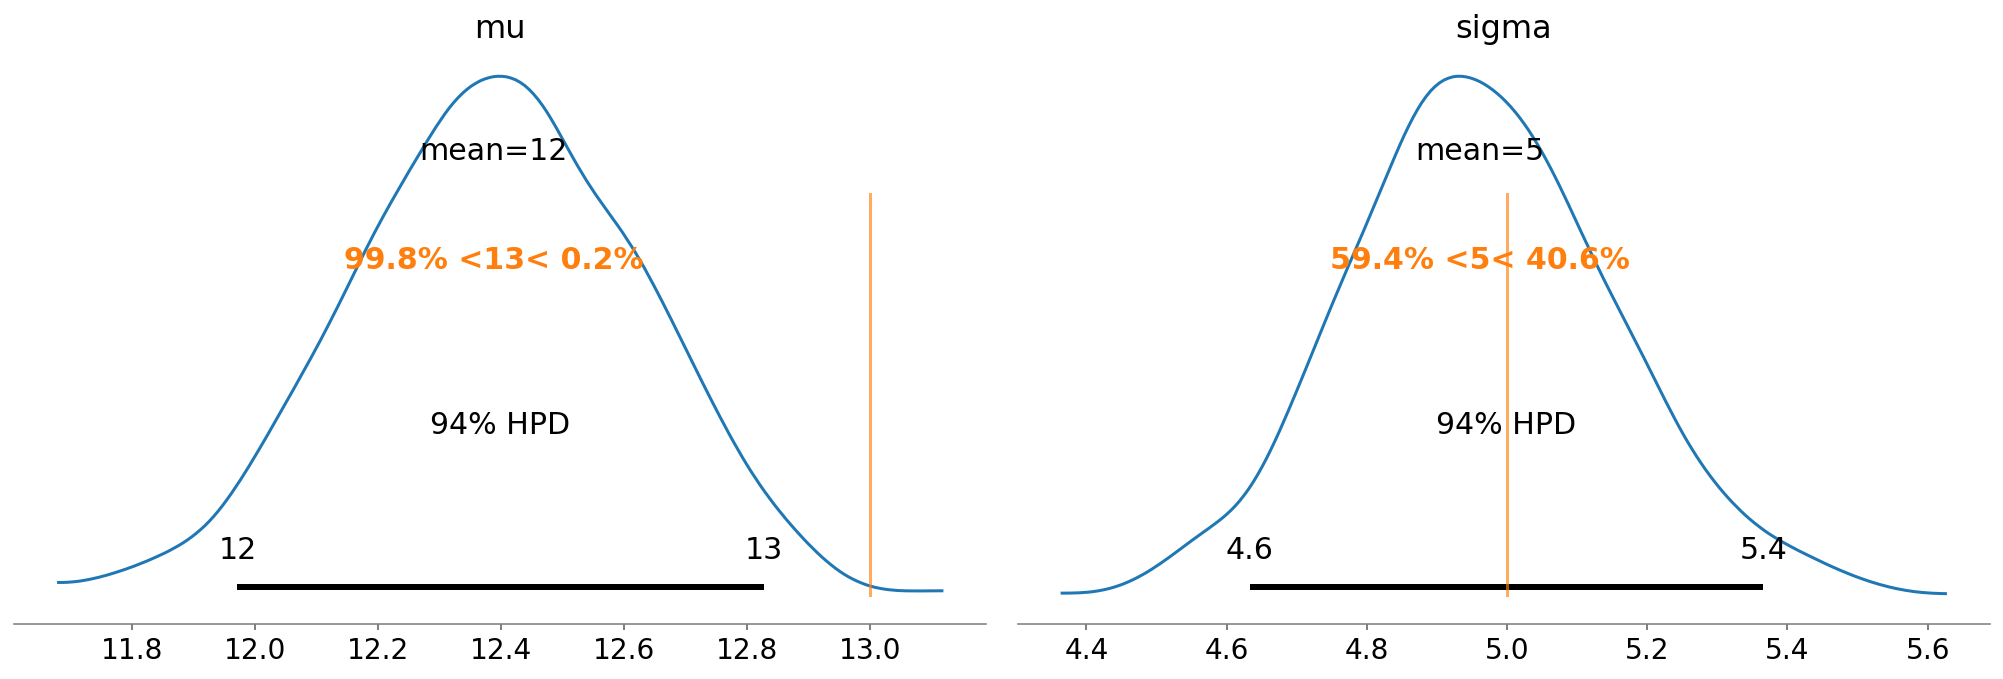

In [38]:
trace = model1(samples)
az.plot_posterior(trace, var_names=["mu", "sigma"], ref_val=[μ, σ])